# **Capstone project: Providing data-driven suggestions for HR**

# **PACE stages**


# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


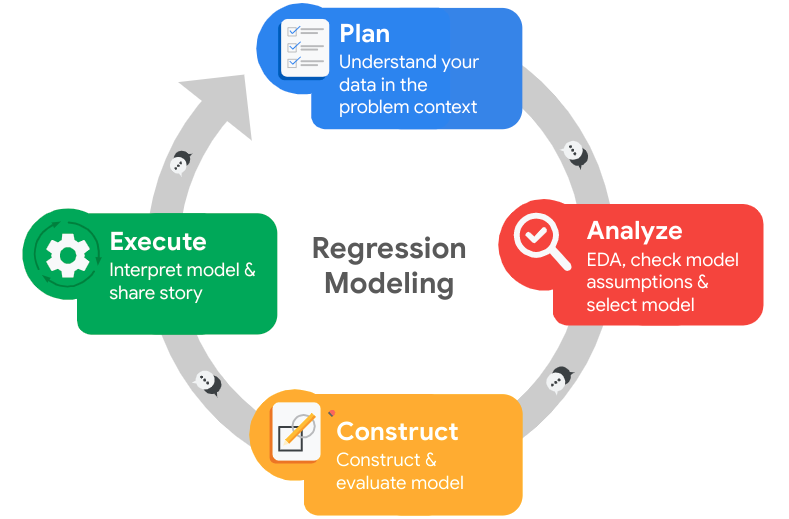

🔎
## Recall model assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size


### Import packages

In [112]:
#Data manipulation
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

#Data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# Package for saving models
import pickle


### Load dataset

Load a dataset called **`HR_capstone_modeling.csv`.**

In [113]:
#load the dataframe without tenure outliers
df1=pd.read_csv("HR_capstone_modeling.csv")

#first few rows
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


💭
### Reflect on these questions as you complete the constructing stage.

- Do you notice anything odd?
- Which independent variables did you choose for the model and why?
- Are each of the assumptions met?
- How well does your model fit the data?
- Can you improve it? Is there anything you would change about the model?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?



**Reflecting for Construct Stage**
1. Independent variable chosen are: 'satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure'. 
2. Two variables (departments and salary) are categorical variables that need to be converted in order to include in the models.
3. Logistic regression model is vulnerable to outliers, which will be considered when constructing this model.

## Step 3. Model Building  &  Step 4. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model



#### Identify the type of prediction task.

The prediction task is whether an employee leaves the company. The 'left' variable is categorical with 1 indicating the employee left or 0 if did not leave.

#### Identify the types of models most appropriate for this task.

For categorical variables the possible models are Logistic Regression or a Tree based Machine Learning model.

### Modeling


**Approach A: Logistic Regression Model**

Variables 'salary' and 'department' are object data types. These need to be converted in categorical levels

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   tenure                 11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 936.9+ KB


In [5]:
#Create a copy of the dataset
df1_copy = df1.copy()
#Encode the 'salary' column as an ordinal numeric category
df1_copy['salary'] = (
    df1_copy['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

#Dummy the 'department' column
df1_copy = pd.get_dummies(df1_copy, columns=['department'], drop_first=False, dtype=int)


#Dsiplay new dataframe head
df1_copy.head()


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Create a heatmap to evaluate the correlation with new encoded columns. Only including relevant variables

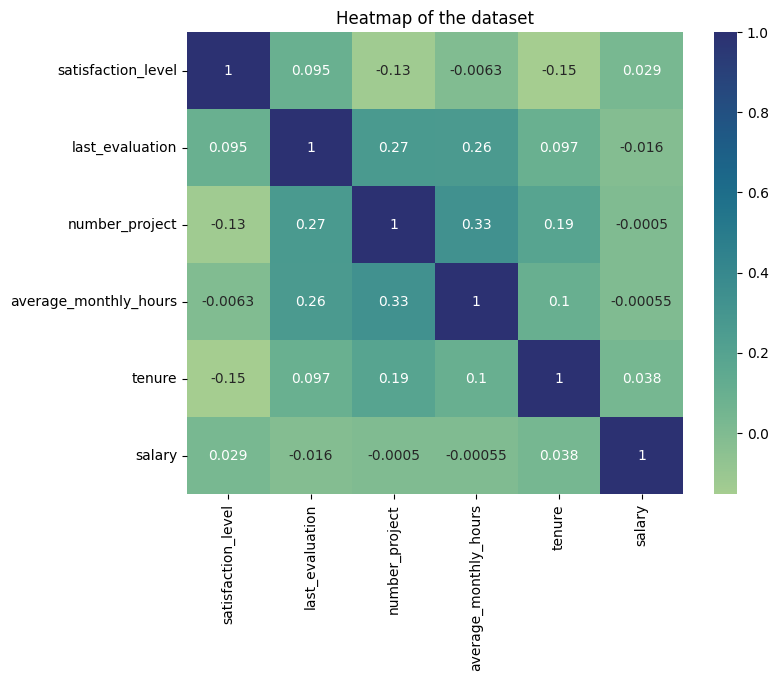

In [7]:
#Heatmap matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df1_copy[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'salary']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

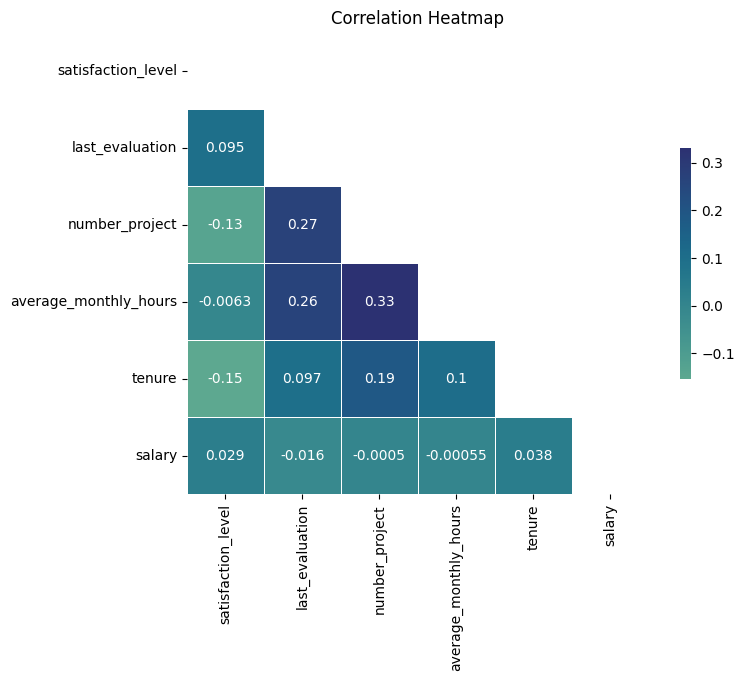

In [8]:
# Reference code from github.com/thanakorntha
# Create a heatmap to visualize how correlated variables are simplified
plt.figure(figsize=(8, 6))

corr = df1_copy[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'salary']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="crest", mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

A bar plot to visualize the number of employees across departments to compare who left and who did not. <br>
Employees who stayed are in blue bars (0) and those who left are in green bars (1).

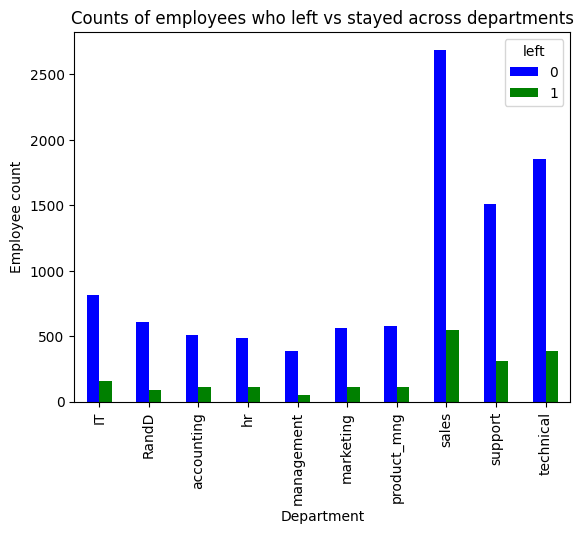

In [10]:
#Create Bar plot for employee count by department comparing whoe left vs who stayed.
pd.crosstab(df1['department'], df1['left']).plot(kind='bar', color= 'bg')
plt.title('Counts of employees who left vs stayed across departments')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Logistic regressions are sensitive to outliers. The tenure column was identified with a group of outliers. <br>
These outliers will be removed to continue with the logistic regression model.

In [11]:
# Determine the number of rows containing outliers

#Compute 25th percentile value in 'tenure'
percentile25=df1_copy['tenure'].quantile(0.25)

#Compute 75th percentile value in 'tenure'
percentile75=df1_copy['tenure'].quantile(0.75)

#Compute the interquartile range in 'tenure'
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

#Identify subset of data containing outliers in 'tenure'
outliers = df1_copy[(df1_copy['tenure']> upper_limit) | (df1_copy['tenure'] < lower_limit)]

#Count how many rows in the data contain outliers for 'tenure'
print("Number of rows in the data containing outliers in 'tenure':", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in 'tenure': 824


In [12]:
#Create new dataframe without outliers in the tenure column
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df1_no_outlier = df1_copy[(df1_copy['tenure']>= lower_limit) & (df1_copy['tenure'] <= upper_limit)]

#Display first rows of new dataframe
df1_no_outlier.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,0.10,0.77,6,247,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7,0.92,0.85,5,259,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
8,0.89,1.00,5,224,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,0.42,0.53,2,142,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
10,0.45,0.54,2,135,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Need to isolate the outcome variable that will be used to predict the model.

In [69]:
#Isolate the outcome variable
ylr = df1_no_outlier['left']

#Display first few rows
ylr.head()


0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

Features selected to use in the model that can predict the outcome variable 'left'

In [70]:
#Select the features you want to use in your model
Xlr = df1_no_outlier.drop('left', axis =1)

#Display first few rows
Xlr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


Splitting data into training set and testing set. 

In [71]:
#Split data into training and testing sets
Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(Xlr,ylr, test_size = 0.25, stratify =ylr, random_state= 35)

Perform Logistic regression model and fit it to training dataset

In [72]:
#Construct a logistic regression model and fit it to the training dataset
log_clf= LogisticRegression(random_state= 35, max_iter= 500).fit(Xlr_train, ylr_train)

Testing the model to make predictions on the test set.

In [73]:
#Use the logistic regression model to get predictions on the test set
ylr_pred = log_clf.predict(Xlr_test)

Confusion matrix visualization of the logistic regression model.

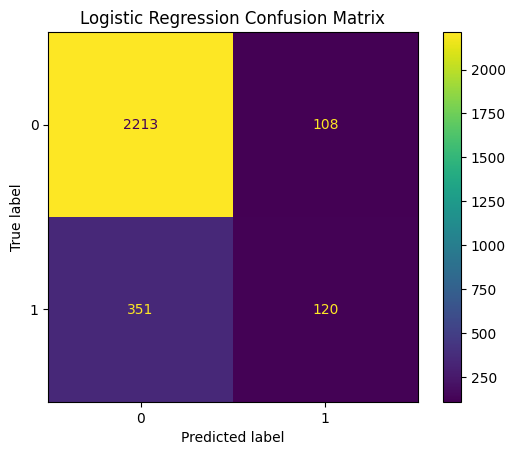

In [74]:
#Compute values for confusion matrix
log_cmlr = confusion_matrix(ylr_test, ylr_pred, labels=log_clf.classes_)

#Create display of confusion matrix
log_displr = ConfusionMatrixDisplay(confusion_matrix=log_cmlr, 
                                  display_labels=log_clf.classes_)

#Plot confusion matrix
log_displr.plot(values_format='')

#Display plot
plt.show(
plt.title('Logistic Regression Confusion Matrix'))

The confusion matrix quadrants are:
1. The upper-left quadrant displays the number of true negatives. 
2. The upper-right quadrant displays the number of false positives. 
3. The bottom-left quadrant displays the number of false negatives. 
4. The bottom-right quadrant displays the number of true positives.

The results show for each quadrant:
1. True negatives: The number of people (2213) who did not leave that the model accurately predicted did not leave.
2. False positives: The number of people (108) who did not leave the model inaccurately predicted as leaving.
3. False negatives: The number of people (351) who left that the model inaccurately predicted did not leave.
4. True positives: The number of people (120) who left the model accurately predicted as leaving.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

#### Evaluate the logistic regression model


Validate the class balance by checking the value counts of 'left' column. The class balance will inform how to interpret th accuracy metrics.

In [19]:
# value counts for 'left' column
df1_no_outlier['left'].value_counts(normalize= True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

The results for the class balance are 83% to 17% split. It is not balanced, but also not greatly imbalanced. In this case, I will continue to evaluate the model.

Create a classification report including precision, recall, f1-score, and accuracy.

In [75]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(ylr_test, ylr_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.95      0.91      2321
    Predicted would leave       0.53      0.25      0.34       471

                 accuracy                           0.84      2792
                macro avg       0.69      0.60      0.62      2792
             weighted avg       0.81      0.84      0.81      2792



The classification report indicates that the logistic regression achieved a precision of 81%, recall of 84%, f1-score of 81% all in weighted averages. But in case of predicting employees who leave the scores are significantlt lower (i.e 53%, 25%, and 34% respectively.)

**Approach B: Tree-based Model**

This will cover the Decision Tree and Random Forest.

In [76]:
# Isolate the outcome variable
ydt = df1_copy['left']

# Display the first few rows of `y`
ydt.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [77]:
#Select features
Xdt = df1_copy.drop('left', axis =1)

#Display first few rows
Xdt.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [78]:
# Split the data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(Xdt, ydt, test_size=0.25, stratify=ydt, random_state=42)

#### Decision tree - Round 1

Decision tree model construction and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [79]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid
cv_params = {'max_depth': [4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]}

# Define scoring (multiple metrics)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Perform grid search
grid_search = GridSearchCV(estimator=tree, param_grid=cv_params, scoring=scoring, refit='accuracy')
grid_search.fit(Xdt_train, ydt_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [80]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid
cv_params = {'max_depth': [4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]}

# Define scoring metrics (multiple metrics)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearchCV with cross-validation
tree1 = GridSearchCV(estimator=tree, 
                     param_grid=cv_params, 
                     scoring=scoring, 
                     cv=4, 
                     refit='roc_auc')

# Fit the model (ensure Xdt_train and ydt_train are defined)
tree1.fit(Xdt_train, ydt_train)


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

Fit decision tree model to the training data

Identify the optimal values for the decision tree parameters.

In [25]:
#Checking best parameters
tree1.best_params_
print("Best parameters found:", tree1.best_params_)


Best parameters found: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}


Best AUC score achieve by the decision tree model on the training set

In [26]:
# Check best score based on 'roc_auc'
print("Best ROC AUC score:", tree1.best_score_)

Best ROC AUC score: 0.9758952535925409


The AUC score is strong, which show that this model can predict well if employees will leave. <br>

Write a function that will help extract all the scores from the grid search.

In [28]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [29]:
#Get all the scores from the grid search from the function defined above (make_results)
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.966878,0.918288,0.941941,0.981208,0.975895


The score results from the decision tree model are very strong indicator of good model performance. <br>

Decision tree models are susceptible of overfitting and random forest avoid the overfitting by incorporating multiple trees to make predictions.


#### Random forest - Round 1

Random forest construction and set up cross-validated grid search for the best model parameters.

In [94]:
# Isolate the outcome variable
yrf = df1_copy['left']

# Display the first few rows of `y`
yrf.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [95]:
#Select features
Xrf = df1_copy.drop('left', axis =1)

#Display first few rows
Xrf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [96]:
# Split the data
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(Xrf, yrf, test_size=0.25, stratify=yrf, random_state=40)

In [97]:
# Instantiate model
rf = RandomForestClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the random forest to the training data

In [98]:
%%time 
rf1.fit(Xrf_train, yrf_train) #wall time 23 min 20s

CPU times: total: 19min 44s
Wall time: 19min 48s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

Saving the model into a specific path

In [42]:
#Path to the folder where the model will be saved
path = 'C:/Users/mvvb8/Documents/GitHub/Salifort_Motors'

Define functions to pickle the model and read in the model

In [114]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [115]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

Using functions defined above(write_pickle and read_pickle) to save the model in a pickle file and read it.

In [116]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1.p')

In [117]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1.p')

Identify the best AUC score achieved by the random forest model on the training set

In [118]:
#Check best AUC score on CV
rf1.best_score_

np.float64(0.979228420620015)

Optimal values for the parameters of the random forest model

In [119]:
#Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

Collect the evaluation scores on the training set for the decision tree and random forest models.

In [120]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975895
              model  precision    recall        F1  accuracy       auc
0  random forest cv     0.9594  0.914268  0.936259  0.979318  0.979228


Results show that the random frest model is better than those of the decision tree model, except for the recall score by 0.001 which is a negligible amount. Concluding the random forest model is better.

Evaluate the final model in the test set.

In [123]:
def get_scores(model_name:str, model, Xrf_test_data, yrf_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        Xrf_test_data:          numpy array of Xrf_test data
        yrf_test_data:          numpy array of yrf_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(Xrf_test_data)

    auc = roc_auc_score(yrf_test_data, preds)
    accuracy = accuracy_score(yrf_test_data, preds)
    precision = precision_score(yrf_test_data, preds)
    recall = recall_score(yrf_test_data, preds)
    f1 = f1_score(yrf_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

Using the random forest model to predict on the test set.

In [124]:
#Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, Xrf_test, yrf_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.950719,0.929719,0.940102,0.98032,0.960059


These test scores look similar to the validation scores, confirming the random forest model is strong.

##### Feature Engineering

In order to confirm these high evaluation scores, another round of model training and testing sets should be performed. Employees that are likely to leave or are to be fired might work less or even overworked if the employee needs to complete tasks or projects before leaving the company. On the other hand employees that will let go might work less as well. This possibilities can cause data leakeage. The 'average_monthly_hours' column might be the source of the data leakeage. 
An approach could be to drop the 'satisfaction_level' from the variables and create a new feature that can capture whether an employee is overworked.

In [125]:
#Create a new feature in a new dataframe
df2= df1_copy.drop('satisfaction_level', axis =1)

#Display first few rows
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [126]:
#Create 'overworked' column, for now it would be same as 'average_monthly_hours'
df2['overworked']= df2['average_monthly_hours']

#Inspect the max and min average monthly hours
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

Max hours: 310
Min hours: 96


With the results above in which the range of average monthly hours is from 96 to 310 hours. Approximately monthly hours of working is 166.67 for an employee  50 weeks a year, 5 days a week for 8 hours per day. It could be defined that overworking is > 175 hrs per month on average. 

Convert the 'overworked' column into binary and reassign it using boolean mask. <br>
- ['overworked'] > 175  creates a series of booleans, where > 175 is True and False for every value less than 175. 
- .astype(int) converts all True as 1 and all False as 0. 

In [127]:
#Define 'overworked' as working > 175/hr/week
df2['overworked']=(df2['overworked']> 175).astype(int)

# Display first few rows of new column
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

Now, the 'average_monthly_hours' column can be dropped.


In [128]:
#Drop column 
df2 = df2.drop(['average_monthly_hours'], axis = 1)

#Display first rows of df2 dataframe
df2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


Isolating the features and target variables

In [129]:
#Isolate the outcome variable
y2= df2['left']

#Select the features
X2 = df2.drop('left', axis =1)

Split the data into training and testing sets.

In [130]:
#Create test data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.25, stratify=y2, random_state=0)

#### Decision Tree - Round 2

In [131]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state=0)

# Define hyperparameter grid
cv_params = {'max_depth': [4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]}

# Define scoring metrics (multiple metrics)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearchCV with cross-validation
tree2 = GridSearchCV(estimator=tree, 
                     param_grid=cv_params, 
                     scoring=scoring, 
                     cv=4, 
                     refit='roc_auc')

# Fit the model (ensure X2_train and y2_train are defined)
tree2.fit(X2_train, y2_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [132]:
%time
tree2.fit(X2_train, y2_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [133]:
#Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [134]:
# Check best AUC score on CV
tree2.best_score_

np.float64(0.9586752505340426)

This AUC score of 0.96 performs very well removing satisfactory_levels and detailing the overworked data.

Checking other scores:

In [135]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
#Compare round 1 vs 2
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975895
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Plotting a confusion matrix for Decision Tree Model for Round 2

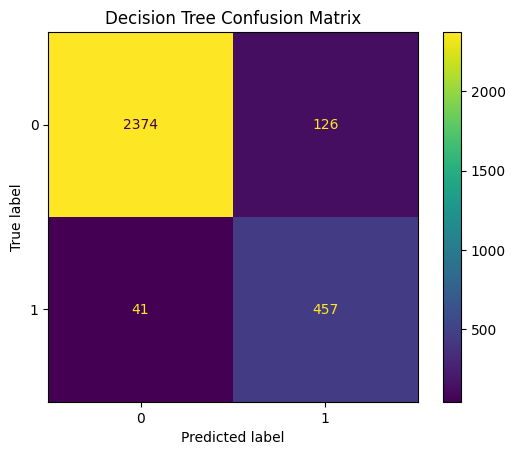

In [149]:
# Generate array of values for confusion matrix
preds = tree2.best_estimator_.predict(X2_test)
cm = confusion_matrix(y2_test, preds, labels=tree2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tree2.classes_)
disp.plot(values_format='')
plt.title('Decision Tree Confusion Matrix');

Decision tree round 2 has lower scores compared to round 1. This makes sense given that features were reduced in round 2. But overall scores are good.

#### Random forest - Round 2

In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state=10)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%time
rf2.fit(X2_train, y2_train) # wall time was 21min 42sec

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [141]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [142]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [143]:
# Check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [144]:
# Check best AUC score on CV
rf2.best_score_

np.float64(0.9648100662833985)

Comparing Decision Tree vs Random Forest for Round 2

In [145]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


Both models scores dropped a little compared to Round 1 where all hyper parameters were used. 
The random forest model performs better than the decision tree model if using the AUC score. 
-   AUC score sums up how well a model can produce relative scores to discriminate between positive or negative instances across all classification thresholds. The ROC AUC score ranges from 0 to 1, where 0.5 indicates random guessing, and 1 indicates perfect performance. [Reference]('https://www.evidentlyai.com/classification-metrics/explain-roc-curve')

Scoring the best model on the test set: Random Forest model (Round2)

In [146]:
#Predictions on test data
rf2_test_scores= get_scores('random forest2 test', rf2, X2_test, y2_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


This results seem adecuate and well performed final model

Plotting a confusion matrix to visualize how well prediction on the test set

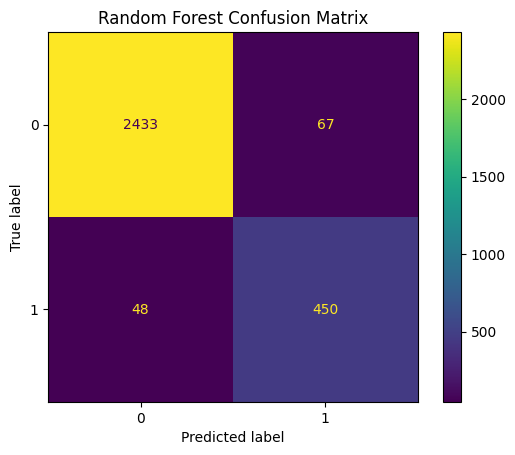

In [147]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X2_test)
cm = confusion_matrix(y2_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='')
plt.title('Random Forest Confusion Matrix');

The matrix predicts more false positive than false negatives, meaning that some employees may be identified as at risk of quitting or getting fired, when actually is not the case.


Exploring the splits of the decision tree model and the most important features in the random forest model.

**Decision tree splits**

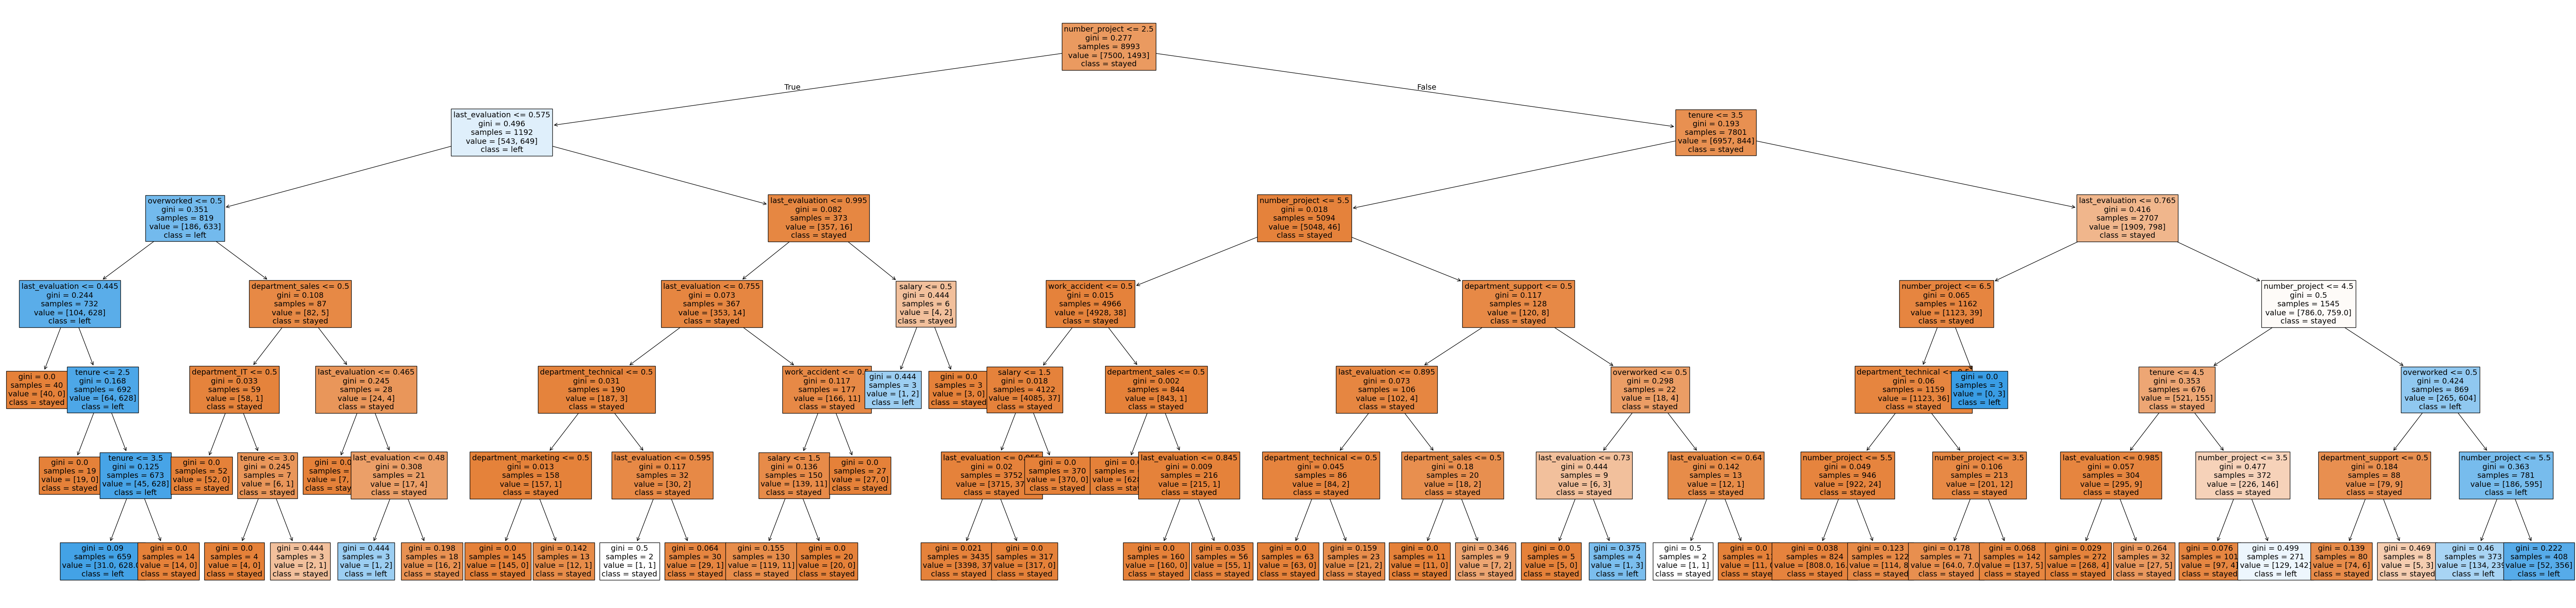

In [148]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X2.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### XGBoost Model

In [63]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


Prepare data for predictions

In [82]:
#Define the y variable
ygb= df1_copy['left']

#Define the X variable
Xgb= df1_copy.drop('left', axis =1)

#Split into train and test sets
Xgb_train, Xgb_test, ygb_train, ygb_test = train_test_split( Xgb, ygb, test_size= 0.25, stratify= ygb, random_state= 30)

In [83]:
print(ygb.unique())
print(ygb.value_counts())
print(ygb.dtype)

[1 0]
left
0    10000
1     1991
Name: count, dtype: int64
int64


In [84]:
#Instatiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=30)

#Create dictionary of hyperparameters to tune
cv_params={'max_depth' : [4,6],
           'min_child_weight' : [3,5],
           'n_estimators' : [5,10,15],
           'subsample' : [0.7],
           'colsample_bytree' : [0.7]          
           }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy','precision', 'recall', 'f1' ]


# Instantiate GridSearch
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit= 'f1')

In [85]:
#Fit the model

xgb_cv.fit(Xgb_train, ygb_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [86]:
#Check best params
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

In [87]:
# Check best AUC score on CV
xgb_cv.best_score_

np.float64(0.9402241825598724)

In [88]:
# use pickle to save the training model.
pickle.dump(xgb_cv, open('xgb_model.p', 'wb'))

#### Formulate predictions on your test set

To evaluate the predictions yielded from XGBoost model, a series of metrics and evaluation techniques were leaveraged from scikit-learn by examining the actual observed values in the test set relative to your model's prediction.

First, I use the trained model to formulate predictions on your test set.

In [89]:
# Apply your model to predict on your test data. Call this output "y_pred".
ygb_pred = xgb_cv.predict(Xgb_test)

In [ ]:
# 1. Print the accuracy score.

ac_score = metrics.accuracy_score(ygb_test, ygb_pred)
print('accuracy score:', ac_score)

# 2. Print the precision score.

pc_score = metrics.precision_score(ygb_test, ygb_pred)
print('precision score:', pc_score)

# 3. Print the recall score.

rc_score = metrics.recall_score(ygb_test, ygb_pred)
print('recall score:', rc_score)

# 4. Print the f1 score.

f1_score = metrics.f1_score(ygb_test, ygb_pred)
print('f1 score:', f1_score)

accuracy score: 0.9819879919946631
precision score: 0.9763948497854077
recall score: 0.9136546184738956
f1 score: 0.9439834024896265


Text(0.5, 1.0, 'XGBoost Confusion Matrix')

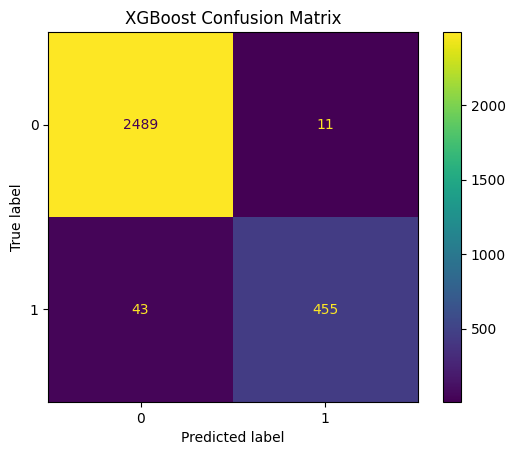

In [ ]:
# Construct the confusion matrix for the predicted and test values.
cm = metrics.confusion_matrix(ygb_test, ygb_pred)

# Create the display for your confusion matrix.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

# Plot the visual in-line.
disp.plot()
plt.title('XGBoost Confusion Matrix')